In [1]:

# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import os

# Add src directory to path for importing our modules
sys.path.append('../src')

# Import our custom data processing module
from data_processing import DataLoader, AggregateCustomerFeatures, OutlierHandler, DateTimeFeatureExtractor

print("✅ Libraries imported")

✅ Libraries imported


In [2]:
# Cell 2: Load and Inspect Data
# -------------------------------------------------------------
loader = DataLoader("../data/raw/transaction_data.csv")  # Update path
raw_df = loader.load()

print("First few rows:")
display(raw_df.head())

print("\nData Info:")
raw_df.info()

✅ Data loaded: 95662 rows, 16 columns
First few rows:


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   TransactionId         95662 non-null  object             
 1   BatchId               95662 non-null  object             
 2   AccountId             95662 non-null  object             
 3   SubscriptionId        95662 non-null  object             
 4   CustomerId            95662 non-null  object             
 5   CurrencyCode          95662 non-null  object             
 6   CountryCode           95662 non-null  int64              
 7   ProviderId            95662 non-null  object             
 8   ProductId             95662 non-null  object             
 9   ProductCategory       95662 non-null  object             
 10  ChannelId             95662 non-null  object             
 11  Amount                95662 non-null  float64          

In [3]:
# Cell 3: Create Customer Aggregates (RFM Features)
# -------------------------------------------------------------
print("="*60)
print("CREATING CUSTOMER-LEVEL AGGREGATES (RFM)")
print("="*60)

aggregator = AggregateCustomerFeatures()
df_with_agg = aggregator.fit_transform(raw_df)

# Display the new aggregate features
print("\nNew aggregate columns created:")
agg_columns = [col for col in df_with_agg.columns if col not in raw_df.columns]
print(agg_columns)
print("\nSample of customer aggregates:")
display(df_with_agg[['CustomerId'] + agg_columns].head())

CREATING CUSTOMER-LEVEL AGGREGATES (RFM)
✅ Customer aggregates merged. Shape: (95662, 24)

New aggregate columns created:
['transaction_count', 'amount_median', 'amount_std', 'value_median', 'last_transaction', 'first_transaction', 'recency_days', 'frequency_per_month']

Sample of customer aggregates:


,CustomerId,transaction_count,amount_median,amount_std,value_median,last_transaction,first_transaction,recency_days,frequency_per_month
0,CustomerId_4406,119,500.0,3042.29,1000.0,2019-02-12 10:24:40+00:00,2018-11-15 02:18:49+00:00,1,40.112360
1,CustomerId_4406,119,500.0,3042.29,1000.0,2019-02-12 10:24:40+00:00,2018-11-15 02:18:49+00:00,1,40.112360
2,CustomerId_4683,2,500.0,0.00,500.0,2018-11-24 08:30:25+00:00,2018-11-15 02:44:21+00:00,82,6.666667
3,CustomerId_988,38,1000.0,17169.24,2000.0,2019-02-08 07:53:33+00:00,2018-11-15 03:32:55+00:00,6,13.411765
4,CustomerId_988,38,1000.0,17169.24,2000.0,2019-02-08 07:53:33+00:00,2018-11-15 03:32:55+00:00,6,13.411765


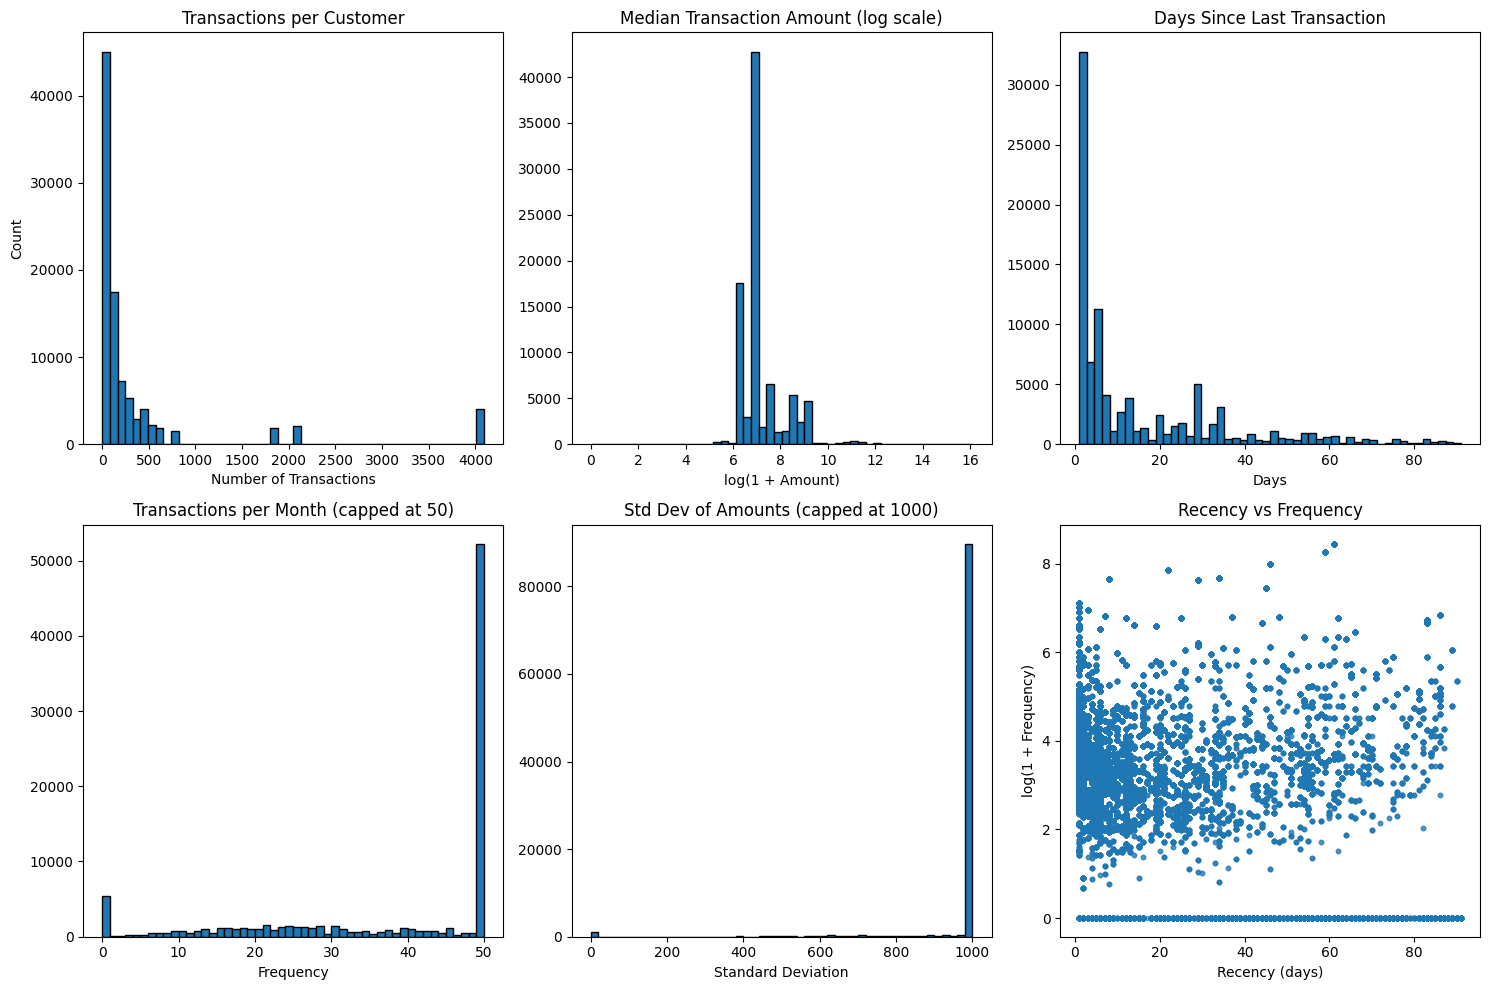

In [4]:
# Cell 4: Visualize the New RFM Features
# -------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Transaction count distribution
axes[0, 0].hist(df_with_agg['transaction_count'].dropna(), bins=50, edgecolor='black')
axes[0, 0].set_title('Transactions per Customer')
axes[0, 0].set_xlabel('Number of Transactions')
axes[0, 0].set_ylabel('Count')

# Plot 2: Median amount distribution (log scale due to skew)
axes[0, 1].hist(np.log1p(df_with_agg['amount_median'].dropna()), bins=50, edgecolor='black')
axes[0, 1].set_title('Median Transaction Amount (log scale)')
axes[0, 1].set_xlabel('log(1 + Amount)')

# Plot 3: Recency distribution
axes[0, 2].hist(df_with_agg['recency_days'].dropna(), bins=50, edgecolor='black')
axes[0, 2].set_title('Days Since Last Transaction')
axes[0, 2].set_xlabel('Days')

# Plot 4: Frequency distribution
axes[1, 0].hist(df_with_agg['frequency_per_month'].clip(upper=50).dropna(), bins=50, edgecolor='black')
axes[1, 0].set_title('Transactions per Month (capped at 50)')
axes[1, 0].set_xlabel('Frequency')

# Plot 5: Amount variability
axes[1, 1].hist(df_with_agg['amount_std'].fillna(0).clip(upper=1000), bins=50, edgecolor='black')
axes[1, 1].set_title('Std Dev of Amounts (capped at 1000)')
axes[1, 1].set_xlabel('Standard Deviation')

# Plot 6: Scatter: Frequency vs Recency
scatter = axes[1, 2].scatter(
    df_with_agg['recency_days'], 
    np.log1p(df_with_agg['frequency_per_month']),
    alpha=0.5, s=10
)
axes[1, 2].set_title('Recency vs Frequency')
axes[1, 2].set_xlabel('Recency (days)')
axes[1, 2].set_ylabel('log(1 + Frequency)')

plt.tight_layout()
plt.show()


In [5]:
# Cell 5: Handle Outliers in Amount/Value
# -------------------------------------------------------------
print("="*60)
print("HANDLING OUTLIERS IN AMOUNT/VALUE")
print("="*60)

outlier_handler = OutlierHandler()
df_outlier_handled = outlier_handler.fit_transform(df_with_agg)

# Compare original vs transformed
print("\nComparison of Amount columns:")
amount_stats = pd.DataFrame({
    'Original': [
        df_with_agg['Amount'].min(),
        df_with_agg['Amount'].max(),
        df_with_agg['Amount'].median(),
        df_with_agg['Amount'].std()
    ],
    'Capped': [
        df_outlier_handled['Amount_capped'].min(),
        df_outlier_handled['Amount_capped'].max(),
        df_outlier_handled['Amount_capped'].median(),
        df_outlier_handled['Amount_capped'].std()
    ],
    'Log_Transformed': [
        df_outlier_handled['Amount_log'].min(),
        df_outlier_handled['Amount_log'].max(),
        df_outlier_handled['Amount_log'].median(),
        df_outlier_handled['Amount_log'].std()
    ]
}, index=['Min', 'Max', 'Median', 'Std Dev'])

display(amount_stats)


HANDLING OUTLIERS IN AMOUNT/VALUE
✅ Outliers handled. Original range: [-1000000, 9880000]
   Capped range: [-4325, 7075]

Comparison of Amount columns:


,Original,Capped,Log_Transformed
Min,-1.000000e+06,-4325.000000,0.693147
Max,9.880000e+06,7075.000000,9.341544
Median,1.000000e+03,1000.000000,8.580544
Std Dev,1.233068e+05,3210.808287,2.411064


In [6]:
# Cell 6: Extract DateTime Features
# -------------------------------------------------------------
print("="*60)
print("EXTRACTING DATE/TIME FEATURES")
print("="*60)

dt_extractor = DateTimeFeatureExtractor()
df_final = dt_extractor.fit_transform(df_outlier_handled)

# Show new datetime features
dt_features = ['transaction_hour', 'transaction_day', 'transaction_month', 
               'transaction_dayofweek', 'is_weekend']
print(f"\nNew datetime features: {dt_features}")

print("\nTransaction hour distribution:")
display(df_final['transaction_hour'].value_counts().sort_index().head())


EXTRACTING DATE/TIME FEATURES
✅ DateTime features extracted

New datetime features: ['transaction_hour', 'transaction_day', 'transaction_month', 'transaction_dayofweek', 'is_weekend']

Transaction hour distribution:


transaction_hour
0     168
1     176
2     289
3     714
4    2329
Name: count, dtype: int64

In [7]:
# Cell 7: Prepare Data for WoE/IV Analysis
# -------------------------------------------------------------
print("="*60)
print("PREPARING FOR WoE/IV ANALYSIS")
print("="*60)

# For WoE, we need a target variable. Since we don't have one yet,
# we'll create a placeholder for demonstration.

# Create a dummy target for WoE demonstration (remove in production)
np.random.seed(42)
df_final['dummy_target'] = np.random.randint(0, 2, size=len(df_final))

print(f"\nDummy target distribution:")
print(df_final['dummy_target'].value_counts(normalize=True))

# Select features for WoE encoding
woe_candidates = [
    'ProductCategory', 'ChannelId', 'CountryCode',
    'transaction_hour', 'transaction_dayofweek'
]

print(f"\nFeatures to analyze with WoE/IV: {woe_candidates}")


PREPARING FOR WoE/IV ANALYSIS

Dummy target distribution:
dummy_target
1    0.500303
0    0.499697
Name: proportion, dtype: float64

Features to analyze with WoE/IV: ['ProductCategory', 'ChannelId', 'CountryCode', 'transaction_hour', 'transaction_dayofweek']


In [8]:
# Cell 8: Implement WoE and IV Calculation
# -------------------------------------------------------------
print("="*60)
print("CALCULATING WEIGHT OF EVIDENCE (WoE) & INFORMATION VALUE (IV)")
print("="*60)

def calculate_woe_iv(df, feature, target, bins=10):
    """
    Calculate Weight of Evidence and Information Value for a feature.
    
    Parameters:
    -----------
    df : DataFrame
        Input data
    feature : str
        Feature name
    target : str
        Target variable name
    bins : int
        Number of bins for continuous features
        
    Returns:
    --------
    woe_df : DataFrame
        DataFrame with WoE and IV calculations
    iv : float
        Information Value
    """
    
    df_copy = df.copy()
    
    # For continuous features, create bins
    if df_copy[feature].dtype in ['int64', 'float64']:
        # Use quantile-based binning
        df_copy[f'{feature}_bin'] = pd.qcut(
            df_copy[feature], 
            q=bins, 
            duplicates='drop'
        )
        feature_bin = f'{feature}_bin'
    else:
        # For categorical, use the categories directly
        df_copy[f'{feature}_bin'] = df_copy[feature].astype(str)
        feature_bin = f'{feature}_bin'
    
    # Group by bins
    grouped = df_copy.groupby(feature_bin)[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'events']
    grouped['non_events'] = grouped['total'] - grouped['events']
    
    # Calculate percentages
    total_events = grouped['events'].sum()
    total_non_events = grouped['non_events'].sum()
    
    # Avoid division by zero
    if total_events == 0 or total_non_events == 0:
        return pd.DataFrame(), 0.0
    
    grouped['pct_events'] = grouped['events'] / total_events
    grouped['pct_non_events'] = grouped['non_events'] / total_non_events
    
    # Calculate WoE with smoothing to avoid log(0)
    smoothing = 0.5
    grouped['woe'] = np.log(
        (grouped['pct_non_events'] + smoothing/total_non_events) / 
        (grouped['pct_events'] + smoothing/total_events)
    )
    
    # Calculate IV component
    grouped['iv_component'] = (grouped['pct_non_events'] - grouped['pct_events']) * grouped['woe']
    
    iv = grouped['iv_component'].sum()
    
    return grouped, iv

# Calculate WoE/IV for each candidate feature
print("\nWoE/IV Analysis Results:\n")

iv_results = []
for feature in woe_candidates[:3]:  # Just do first 3 for demonstration
    try:
        woe_df, iv = calculate_woe_iv(df_final, feature, 'dummy_target')
        iv_results.append({'Feature': feature, 'IV': iv})
        
        print(f"\n{feature}:")
        print(f"  Information Value: {iv:.4f}")
        
        # Interpret IV value [citation:1]
        if iv < 0.02:
            strength = "Not useful"
        elif iv < 0.1:
            strength = "Weak"
        elif iv < 0.3:
            strength = "Medium"
        elif iv < 0.5:
            strength = "Strong"
        else:
            strength = "Suspicious"
        
        print(f"  Predictive Power: {strength}")
        
        # Show WoE values
        if not woe_df.empty:
            print("  Top 5 categories by WoE:")
            display(woe_df.sort_values('woe', ascending=False).head())
            
    except Exception as e:
        print(f"  Error calculating WoE/IV for {feature}: {str(e)}")

# Create summary DataFrame
iv_summary = pd.DataFrame(iv_results).sort_values('IV', ascending=False)
print("\n" + "="*60)
print("FEATURE RANKING BY INFORMATION VALUE")
print("="*60)
display(iv_summary)

CALCULATING WEIGHT OF EVIDENCE (WoE) & INFORMATION VALUE (IV)

WoE/IV Analysis Results:


ProductCategory:
  Information Value: 0.0005
  Predictive Power: Not useful
  Top 5 categories by WoE:


,total,events,non_events,pct_events,pct_non_events,woe,iv_component
ProductCategory_bin,,,,,,,
other,2,0,2,0.000000,0.000042,1.610651,6.738842e-05
movies,175,73,102,0.001525,0.002134,0.333790,2.031178e-04
tv,1279,630,649,0.013163,0.013577,0.030902,1.277638e-05
financial_services,45405,22673,22732,0.473736,0.475545,0.003811,6.895014e-06
airtime,45027,22535,22492,0.470852,0.470524,-0.000697,2.288889e-07



ChannelId:
  Information Value: 0.0002
  Predictive Power: Not useful
  Top 5 categories by WoE:


,total,events,non_events,pct_events,pct_non_events,woe,iv_component
ChannelId_bin,,,,,,,
ChannelId_1,538,261,277,0.005453,0.005795,0.060599,0.000021
ChannelId_2,37141,18509,18632,0.386732,0.389774,0.007836,0.000024
ChannelId_3,56935,28539,28396,0.596302,0.594034,-0.003811,0.000009
ChannelId_5,1048,551,497,0.011513,0.010397,-0.101834,0.000114



CountryCode:
  Information Value: 0.0000
  Predictive Power: Not useful

FEATURE RANKING BY INFORMATION VALUE


,Feature,IV
0,ProductCategory,0.000541
1,ChannelId,0.000167
2,CountryCode,0.000000


In [9]:
# Cell 9: Alternative: Using WoEEncoder from category_encoders
# -------------------------------------------------------------
print("="*60)
print("USING WoEEncoder FROM CATEGORY_ENCODERS LIBRARY")
print("="*60)

# Note: Install first: pip install category_encoders

try:
    from category_encoders import WOEEncoder
    
    # Prepare data for WoE encoding
    X_woe = df_final[woe_candidates].copy()
    y_woe = df_final['dummy_target'].copy()
    
    # Handle missing values
    X_woe = X_woe.fillna('missing')
    
    # Initialize and fit WoE encoder
    woe_encoder = WOEEncoder(cols=woe_candidates, randomized=False, regularization=1.0)
    X_woe_encoded = woe_encoder.fit_transform(X_woe, y_woe)
    
    print("✅ WoE encoding complete")
    print(f"Original shape: {X_woe.shape}")
    print(f"Encoded shape: {X_woe_encoded.shape}")
    
    print("\nSample of encoded values:")
    display(X_woe_encoded.head())
    
    # Show the learned WoE values
    print("\nLearned WoE values for ProductCategory:")
    # The encoder stores mappings in an internal attribute
    # Note: The exact attribute may vary by version
    
except ImportError:
    print("⚠️ category_encoders not installed. Install with: pip install category_encoders")
except Exception as e:
    print(f"⚠️ Error using WoEEncoder: {str(e)}")

USING WoEEncoder FROM CATEGORY_ENCODERS LIBRARY
✅ WoE encoding complete
Original shape: (95662, 5)
Encoded shape: (95662, 5)

Sample of encoded values:


,ProductCategory,ChannelId,CountryCode,transaction_hour,transaction_dayofweek
0,0.000697,0.003811,2.535024e-08,-0.008085,0.019982
1,-0.003811,-0.007836,2.535024e-08,-0.008085,0.019982
2,0.000697,0.003811,2.535024e-08,-0.008085,0.019982
3,0.019600,0.003811,2.535024e-08,0.004374,0.019982
4,-0.003811,-0.007836,2.535024e-08,0.004374,0.019982



Learned WoE values for ProductCategory:


In [10]:
# Cell 10: Final Data Preparation for Modeling
# -------------------------------------------------------------
print("="*60)
print("FINAL DATA PREPARATION")
print("="*60)

# Select final features for modeling
model_features = [
    # RFM features
    'transaction_count', 'amount_median', 'amount_std',
    'value_median', 'recency_days', 'frequency_per_month',
    
    # Processed transaction features
    'Amount_log', 'Value_log', 'Amount_capped',
    
    # DateTime features
    'transaction_hour', 'transaction_dayofweek', 'is_weekend',
    
    # Categorical features (will be one-hot encoded in pipeline)
    'ProductCategory', 'ChannelId', 'CountryCode'
]

# Check which features are available
available_features = [f for f in model_features if f in df_final.columns]
missing_features = [f for f in model_features if f not in df_final.columns]

print(f"Available features for modeling: {len(available_features)}")
print(f"Missing features: {missing_features}")

# Create final feature DataFrame
X_final = df_final[available_features].copy()

print(f"\nFinal feature matrix shape: {X_final.shape}")
print("\nFeature summary:")
display(X_final.describe().round(2))


FINAL DATA PREPARATION
Available features for modeling: 15
Missing features: []

Final feature matrix shape: (95662, 15)

Feature summary:


,transaction_count,amount_median,amount_std,value_median,recency_days,frequency_per_month,Amount_log,Value_log,Amount_capped,transaction_hour,transaction_dayofweek,is_weekend,CountryCode
count,95662.00,95662.00,94950.00,95662.00,95662.00,95662.00,95662.00,95662.00,95662.00,95662.00,95662.00,95662.00,95662.0
mean,392.98,2701.94,18036.96,5352.83,15.64,286.30,7.90,6.79,1449.05,12.45,3.01,0.21,256.0
std,878.63,87094.68,89295.70,86990.11,19.61,590.88,2.41,1.89,3210.81,4.85,1.86,0.41,0.0
min,1.00,-350000.00,0.00,50.00,1.00,0.00,0.69,1.10,-4325.00,0.00,0.00,0.00,256.0
25%,32.00,600.00,3206.56,1000.00,1.00,25.00,8.36,5.62,-50.00,8.00,1.00,0.00,256.0
50%,93.00,1000.00,5896.33,1000.00,6.00,56.02,8.58,6.91,1000.00,13.00,3.00,0.00,256.0
75%,273.00,1500.00,10382.69,4750.00,26.00,190.83,8.87,8.52,2800.00,17.00,4.00,0.00,256.0
max,4091.00,9856000.00,3309916.12,9856000.00,91.00,4680.00,9.34,8.86,7075.00,23.00,6.00,1.00,256.0


In [11]:
# Cell 11: Save Processed Data
# -------------------------------------------------------------
output_path = "../data/processed/model_ready_features.csv"
X_final.to_csv(output_path, index=False)

print(f"\n💾 Feature engineering complete!")
print(f"Processed data saved to: {output_path}")
print(f"Total features created: {len(available_features)}")
print("\nNext steps:")
print("1. In Task 4, replace 'dummy_target' with actual is_high_risk")
print("2. Use the data_processing.py pipeline for consistent preprocessing")
print("3. Proceed to model training with these engineered features")



💾 Feature engineering complete!
Processed data saved to: ../data/processed/model_ready_features.csv
Total features created: 15

Next steps:
1. In Task 4, replace 'dummy_target' with actual is_high_risk
2. Use the data_processing.py pipeline for consistent preprocessing
3. Proceed to model training with these engineered features
